In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('data'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')

# File sizes
test.csv                      305.03MB
train.csv                     58.25MB


In [29]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh - i - noor d...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 math is d...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


We are given a minimal number of data fields here, consisting of:

**`id`:** Looks like a simple rowID    
**`qid{1, 2}`:** The unique ID of each question in the pair    
**`question{1, 2}`:** The actual textual contents of the questions.    
**`is_duplicate`:** The **label** that we are trying to predict - whether the two questions are duplicates of each other.

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



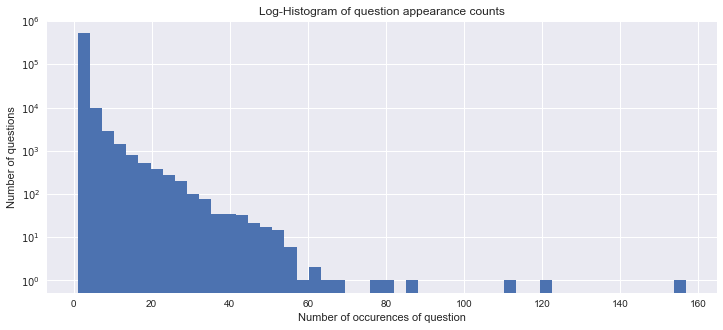

In [30]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [31]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() 
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('data/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('../output/naive_submission.csv', index=False)
sub.head()

Predicted score: 0.658527383984


,is_duplicate,test_id
0,0.369198,0
1,0.369198,1
2,0.369198,2
3,0.369198,3
4,0.369198,4


In [32]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,test_id,question1,question2
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,1,should i have a hair transplant at age 24 how ...,how much cost does hair transplant require
2,2,what but is the best way to send money from ch...,what you send money to china
3,3,which food not emulsifiers,what foods fibre
4,4,how aberystwyth start reading,how their can i start reading


In [33]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796


文本分析

mean-train 59.54 std-train 31.53 mean-test 59.75 std-test 31.20 max-train 1139.00 max-test 1146.00


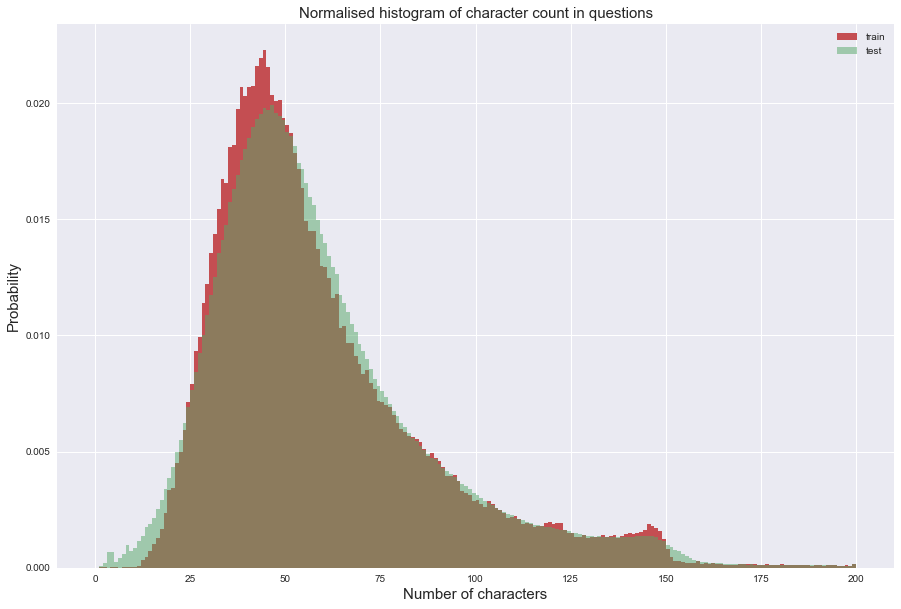

In [34]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

TF-IDF特征的提取

In [35]:
test_qs.head()

0    how does the surface pro himself 4 compare wit...
1    should i have a hair transplant at age 24 how ...
2    what but is the best way to send money from ch...
3                          which food not emulsifiers 
4                       how aberystwyth start reading 
dtype: object

In [36]:
dist_test.head()

0    57
1    65
2    60
3    27
4    30
dtype: int64

mean-train 12.29 std-train 6.08 mean-test 12.26 std-test 6.06 max-train 245.00 max-test 246.00


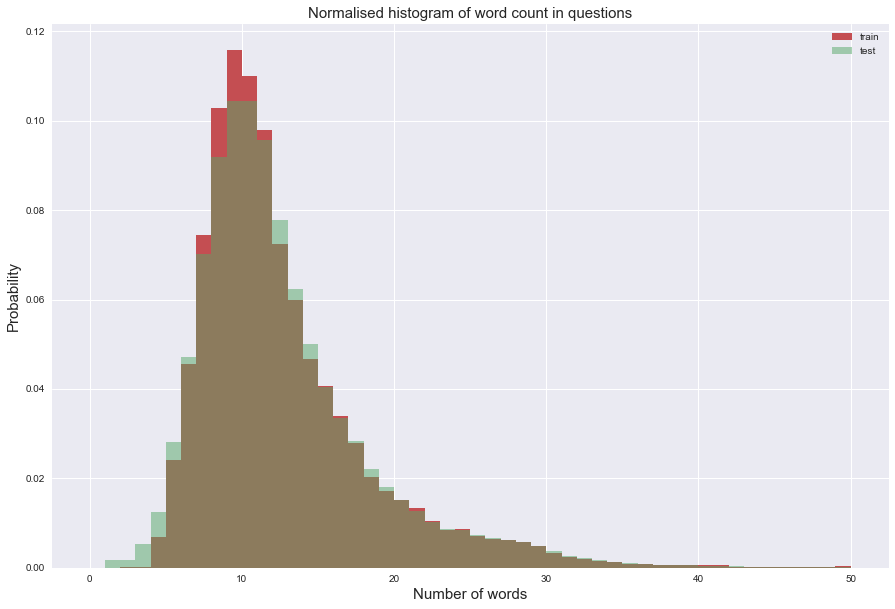

In [37]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

(-0.5, 1439.5, 1079.5, -0.5)

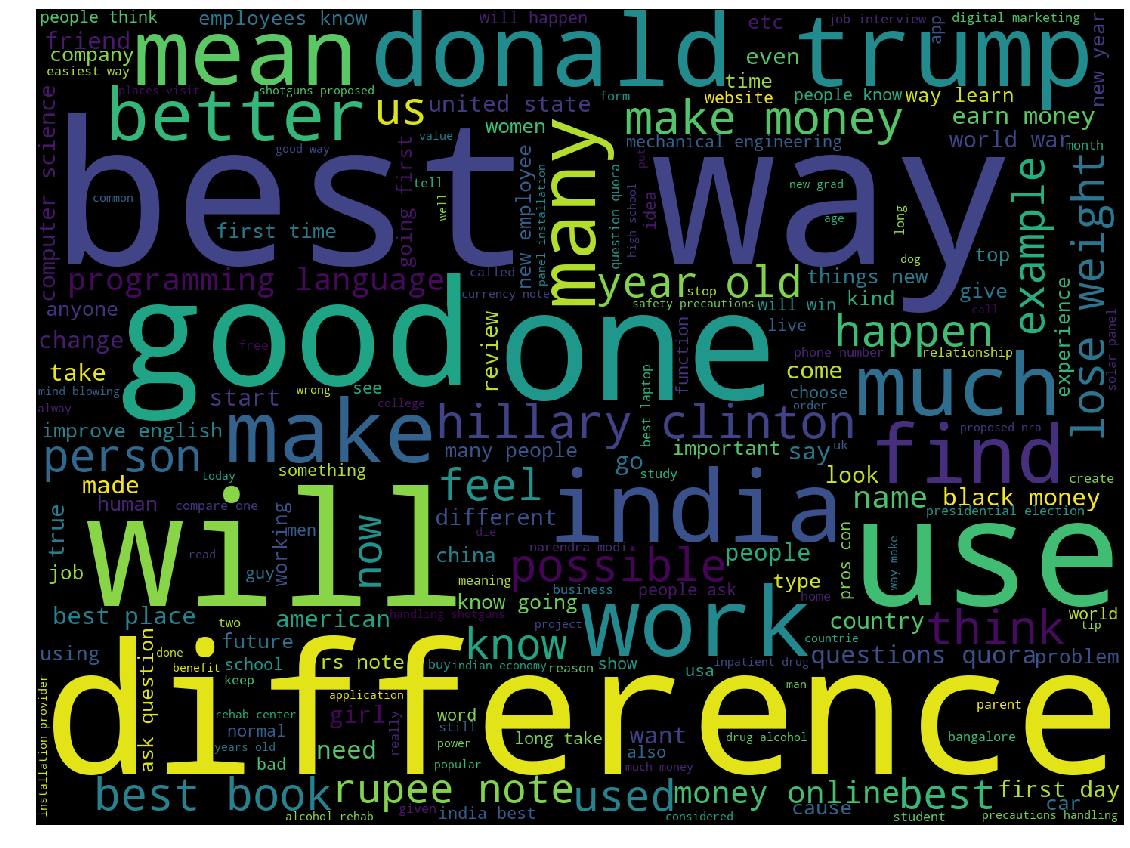

In [38]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [39]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))#首字母是否大写
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))#是否包含大写字母
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))#Python isdigit() 方法检测字符串是否只由数字组成。

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 0.00%
Questions with [math] tags: 0.00%
Questions with full stops: 0.00%
Questions with capitalised first letters: 0.00%
Questions with capital letters: 0.00%
Questions with numbers: 11.83%


In [40]:
#>>import nltk
#>>nltk.download()
from nltk.corpus import stopwords
stops= stopwords.words("english")

from nltk.corpus import sinica_treebank
print(sinica_treebank.words())

['一', '友情', '嘉珍', '和', '我', '住在', '同一條', '巷子', '我們', ...]


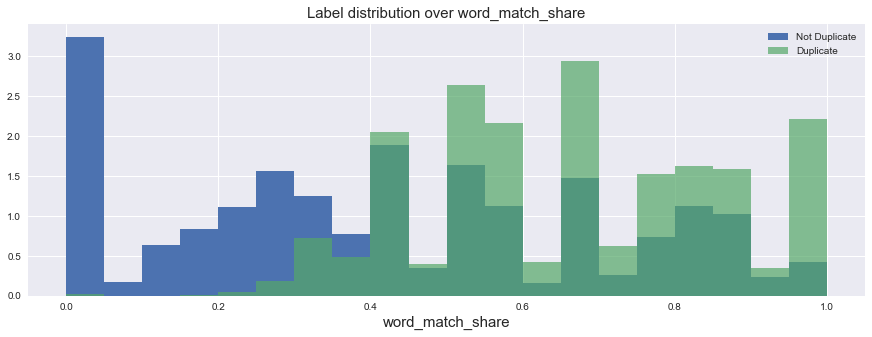

In [41]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:#非停用词，保存到字典
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))#计算q1和q2的非停用词相似度
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [ ]:
#TF-IDF 特征的提取

In [42]:
from collections import Counter
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()#所有出现的词语
counts = Counter(words)#单词计数
print(len(counts))
weights = {word: get_weight(count) for word, count in counts.items()}#计算权值，出现次数越小，权值越大。只出现一次的单词舍去

86005


In [43]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5796865164945155e-06), ('what', 2.9882591298787066e-06), ('is', 3.4063890232520116e-06), ('i', 4.286473603895547e-06), ('how', 4.330916681824875e-06), ('a', 4.499336347888687e-06), ('to', 4.633598220698283e-06), ('in', 4.824485227426234e-06), ('do', 5.58210154959139e-06), ('of', 5.886646730556406e-06)]

Least common words and weights: 


[('1491', 9.998000399920016e-05),
 ('evotracker', 9.998000399920016e-05),
 ('sooraj', 9.998000399920016e-05),
 ('connectionn', 9.998000399920016e-05),
 ('keyloggers', 9.998000399920016e-05),
 ('wholekorea', 9.998000399920016e-05),
 ('khaalu', 9.998000399920016e-05),
 ('jugs', 9.998000399920016e-05),
 ('delicacies', 9.998000399920016e-05),
 ('handjob', 9.998000399920016e-05)]

In [44]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    #重新计算两个句子的相似度，加上权tfidf权值...
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [45]:
df_test.head()

,test_id,question1,question2
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,1,should i have a hair transplant at age 24 how ...,how much cost does hair transplant require
2,2,what but is the best way to send money from ch...,what you send money to china
3,3,which food not emulsifiers,what foods fibre
4,4,how aberystwyth start reading,how their can i start reading


d:\python35\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


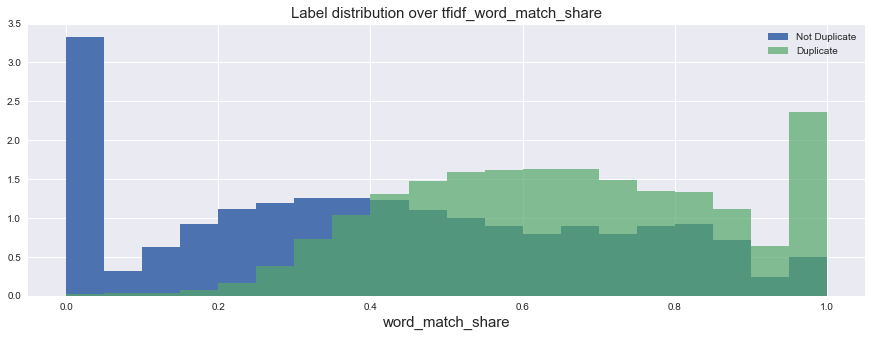

In [46]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [47]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.747158080348
   TFIDF AUC: 0.736967355308


In [48]:
# First we create our training and testing data
x_train = df_train[:]
x_test = df_test[:]
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

d:\python35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python35\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python35\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python35\lib\site-p

In [49]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
x_test.head()

x_train: (404290, 8)
y_train: (404290,)
x_test: (2345796, 5)


,test_id,question1,question2,word_match,tfidf_word_match
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...,0.428571,0.420558
1,1,should i have a hair transplant at age 24 how ...,how much cost does hair transplant require,0.666667,0.664252
2,2,what but is the best way to send money from ch...,what you send money to china,0.666667,0.797515
3,3,which food not emulsifiers,what foods fibre,0.000000,0.000000
4,4,how aberystwyth start reading,how their can i start reading,0.800000,1.000000


In [50]:
x_train['is_duplicate']=y_train
x_train.to_csv('../train/train1.csv',index=None,encoding="utf-8")
x_test.to_csv('../test/test1.csv',index=None,encoding="utf-8")

d:\python35\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
